In [1]:
import numpy as np
import pandas as pd
from statsmodels.formula import api as smf

from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
class DataGenerator:
    def __init__(
        self,
        target_normal_params = {'loc': 0, 'scale': 1},
        treatment_effect: float = 0.0,
        decay_factor: float = 1.0,
        total_panel: int = 52,
        control_group: bool = True
    ):
        self.target_normal_params = target_normal_params
        self.treatment_effect = treatment_effect
        
        self.total_panel = total_panel
        self.is_treatment_group = not control_group

        self.treatment_effects = np.array([treatment_effect*np.exp(-decay_factor*i) for i in range(total_panel)])
    
    def generate_data(self, n_samples:int = 1000, n_surrogates: int = 4):

        full_panel_data = np.clip(np.random.normal(size=(n_samples, self.total_panel), **self.target_normal_params), a_min=0, a_max=np.inf)
        full_panel_data = full_panel_data + self.treatment_effects
        unit_total = full_panel_data.sum(axis=1)
        surrogate_data = full_panel_data[:, :n_surrogates]
        data = (
            pd.DataFrame(
                data = np.hstack([surrogate_data, unit_total.reshape(-1, 1)]), 
                columns=[f"surrogate_{i}" for i in range(n_surrogates)] + ['unit_total']
            )
            .assign(
                treatment = int(self.is_treatment_group),
            )
        )
        return data
    
    def get_mean(self):
        return np.array(self.choice_probability) @ self.choices

In [3]:
t_gen = DataGenerator(
    target_normal_params={'loc': 0, 'scale': 1},
    treatment_effect=5,
    total_panel = 20,
    control_group = False
)
t_data= t_gen.generate_data(n_samples=100, n_surrogates=20)

In [4]:
plot_data = (
    t_data
    .assign(user_id = range(c_data.shape[0]))
    .melt(
        id_vars = ['user_id'],
        value_vars = [f"surrogate_{i}" for i in range(c_gen.total_panel)]
    )
    .assign(
        n_surrogate = lambda df: df.loc[:, 'variable'].map(lambda s: int(s.split('_')[-1]))
    )
)

fig, ax = plt.subplots()
sns.lineplot(
    data = plot_data,
    x = 'n_surrogate',
    y = 'value',
    units = 'user_id',
    estimator = None,
    ax = ax,
    alpha = 0.02,
)
sns.lineplot(
    data = plot_data.query('user_id == 0'),
    x = 'n_surrogate',
    y = 'value',
    ax = ax
)

_ = ax.set_xticks(range(c_gen.total_panel))
_ = ax.set_yticks(range(0, 3))
_ = ax.set_ylim(0, 2)
_ = ax.set_xlabel('Week')
_ = ax.set_ylabel('N Potatoes')
_ = ax.axvline(x=4, color = 'green', linestyle='--')
poly_corners = np.array([
    [0, 0],
    [4, 0],
    [4, 2],
    [0, 2],
    [0, 0]
])
poly = plt.Polygon(poly_corners, edgecolor=None, facecolor='green', alpha=0.15, closed=True)
ax.add_patch(poly)

NameError: name 'c_data' is not defined

<Axes: >

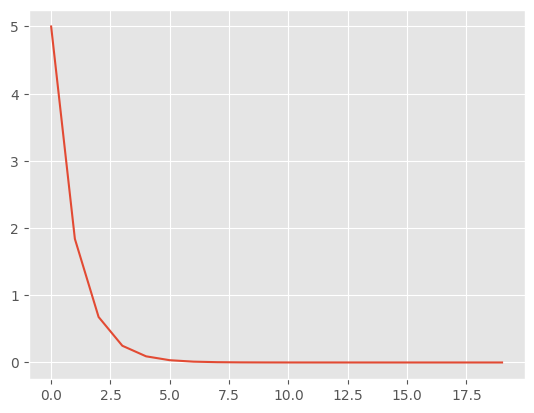

In [5]:
sns.lineplot(t_gen.treatment_effects)

In [6]:
def surrogate_index_model_experiment(
        n_surrogate_list:list = [4],
        sample_size = 1000,
        treatment_effect = 0.0,
        decay_factor = 1.0
    ) -> tuple[float, list[float]]:
    control_data = (
        DataGenerator(
            control_group=True
        )
        .generate_data(
            n_surrogates=max(n_surrogate_list),
            n_samples=sample_size
        )
    )
    treatment_data = (
        DataGenerator(
            treatment_effect=treatment_effect,
            decay_factor=decay_factor,
            control_group=False
        )
        .generate_data(
            n_surrogates=max(n_surrogate_list),
            n_samples=sample_size
        )
    )

    experiment_data = pd.concat([control_data, treatment_data])

    train_data, test_data = train_test_split(experiment_data, test_size=0.5)

    observed_experiment_analysis = (
        smf.ols(
            formula = 'unit_total ~ 1 + treatment',
            data = test_data
        )
        .fit()
    )
    observed_experiment_treatment_effect = observed_experiment_analysis.params['treatment']

    predicted_experiment_treatment_effects = list()

    for n_surrogates in n_surrogate_list:


        surrogate_index_model = (
            smf.ols(
                formula = 'unit_total ~ 1 + ' + ' + '.join([f'surrogate_{i}' for i in range(n_surrogates)]),
                data = train_data
            )
            .fit()
        )
        predicted_test_data = (
            test_data
            .assign(
                predicted_unit_total = surrogate_index_model.predict(test_data)
            )
        )

        predicted_experiment_analysis = (
            smf.ols(
                formula = 'predicted_unit_total ~ 1 + treatment',
                data = predicted_test_data
            )
            .fit()
        )
        predicted_experiment_treatment_effect = predicted_experiment_analysis.params['treatment']
        predicted_experiment_treatment_effects.append(predicted_experiment_treatment_effect)



    return observed_experiment_treatment_effect, predicted_experiment_treatment_effects


In [20]:
observed_effects = list()
predicted_effects = list()
n_surrogate_list = [4, 8, 32, 51]
for i in range(100):
    observed_effect, predicted_effect = surrogate_index_model_experiment(n_surrogate_list=n_surrogate_list, treatment_effect=1/3, decay_factor=0.45)
    observed_effects.append(observed_effect)
    predicted_effects.append(predicted_effect)
predicted_effects = pd.DataFrame(
    data = np.array(predicted_effects),
    columns = n_surrogate_list
)

Text(0.5, 0, 'Treatment Effect')

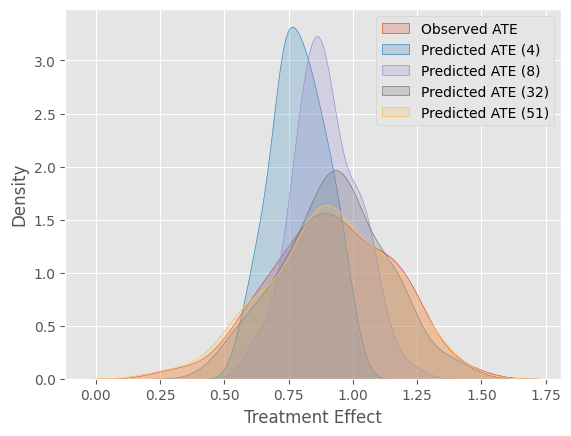

In [21]:
fig, ax = plt.subplots()
sns.kdeplot(observed_effects, label='Observed ATE', ax = ax, fill = True)
for n_surrogates in n_surrogate_list:
    sns.kdeplot(predicted_effects.loc[:, n_surrogates], label=f'Predicted ATE ({n_surrogates})', ax = ax, fill = True)

ax.legend()
ax.set_xlabel('Treatment Effect')

# Explain plots

In [7]:
train_data = (
    DataGenerator(
        control_group=True,
        target_normal_params={'loc': 0, 'scale': 1},
        total_panel = 52
    )
    .generate_data(n_samples=100, n_surrogates=52)
)

In [14]:
control_data = (
    DataGenerator(
        control_group=True
    )
    .generate_data(
        n_surrogates=52,
        n_samples=50
    )
)
treatment_data = (
    DataGenerator(
        treatment_effect=1,
        decay_factor = 0.45,
        control_group=False
    )
    .generate_data(
        n_surrogates=52,
        n_samples=50
    )
)

experiment_data = pd.concat([control_data, treatment_data])

In [15]:
full_data = (
    pd.concat([
        train_data.assign(experiment='train'),
        experiment_data.assign(experiment='experiment')
    ])
    .assign(
        _label = lambda df: df.loc[:, 'experiment'] + ' ' + df.loc[:, 'treatment'].map({0: 'control', 1: 'treatment'}),
        label = lambda df: df.loc[:, '_label'].map(lambda s: 'train' if s.startswith('train') else s)
    )
)

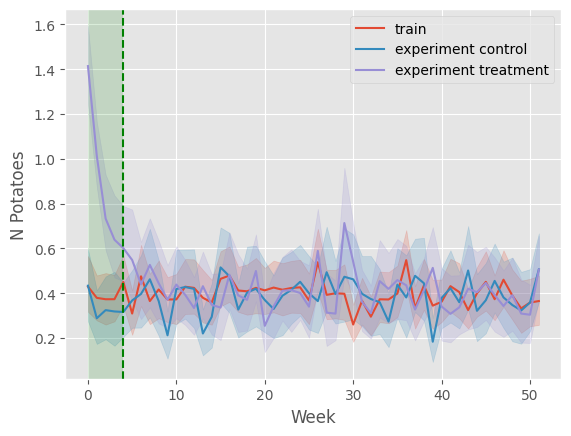

In [16]:
plot_data = (
    full_data
    .assign(user_id = range(full_data.shape[0]))
    .melt(
        id_vars = ['user_id', 'label'],
        value_vars = [f"surrogate_{i}" for i in range(52)]
    )
    .assign(
        n_surrogate = lambda df: df.loc[:, 'variable'].map(lambda s: int(s.split('_')[-1]))
    )
)

fig, ax = plt.subplots()
sns.lineplot(
    data = plot_data,
    x = 'n_surrogate',
    y = 'value',
    hue = 'label',
    ax = ax,
)

_ = ax.legend()
# _ = ax.set_xticks(range(c_gen.total_panel))
# _ = ax.set_yticks(range(0, 3))
# _ = ax.set_ylim(0, 2)
_ = ax.set_xlabel('Week')
_ = ax.set_ylabel('N Potatoes')
_ = ax.axvline(x=4, color = 'green', linestyle='--')
poly_corners = np.array([
    [0, 0],
    [4, 0],
    [4, 2],
    [0, 2],
    [0, 0]
])
poly = plt.Polygon(poly_corners, edgecolor=None, facecolor='green', alpha=0.15, closed=True)
ax.add_patch(poly)